# Detection

## Data
Ensuring your ground truth annotations in the `gt` directory are converted to the YOLO format.

### LettuceMOT

In [18]:
import os
import random
import shutil
import cv2

# Set seed for reproducibility
random.seed(42)

# Define root directory for YOLO data
root_dir = os.path.join('data', 'detection')
train_img_dir = os.path.join(root_dir, 'train', 'images')
train_lbl_dir = os.path.join(root_dir, 'train', 'labels')
val_img_dir = os.path.join(root_dir, 'val', 'images')
val_lbl_dir = os.path.join(root_dir, 'val', 'labels')

# Create YOLO-friendly folder structure
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_lbl_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

# List of source folders with raw data
# Each folder (e.g., "straight1" and "straight2") should have "img" and "gt/gt.txt"
source_dirs = [f'{root_dir}/straight1', f'{root_dir}/straight2']

img_count = 0

for src in source_dirs:
    gt_file = os.path.join(src, 'gt', 'gt.txt')
    if not os.path.exists(gt_file):
        print(f"gt.txt not found in {src}")
        continue

    # Group annotations by frame; each line of gt.txt has:
    # frame_id, track_id, bbox_x, bbox_y, bbox_w, bbox_h, 1, 1, 1
    annotations = {}
    with open(gt_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',')
            if len(parts) < 6:
                continue
            frame_id = parts[0].strip()
            x = float(parts[2])
            y = float(parts[3])
            w = float(parts[4])
            h = float(parts[5])
            if frame_id not in annotations:
                annotations[frame_id] = []
            annotations[frame_id].append((x, y, w, h))

    # Process each frame's annotations
    for frame_id, bboxes in annotations.items():
        # Assume the corresponding image is named "<frame_id>.<ext>"
        # Try common extensions
        possible_extensions = ['jpg', 'png', 'jpeg']
        img_path = None
        for ext in possible_extensions:
            candidate = os.path.join(src, 'img', f"{int(frame_id):06d}.{ext}")
            if os.path.exists(candidate):
                img_path = candidate
                break
        if img_path is None:
            print(f"Image for frame {frame_id} not found in {src}")
            continue

        # Read image to get dimensions (width, height)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Could not read image {img_path}")
            continue
        height, width = img.shape[:2]

        # Convert each bbox to YOLO format: <class_id> <x_center> <y_center> <w> <h>
        # Normalized by image width and height; class id is 0 (lettuce)
        yolo_lines = []
        for bbox in bboxes:
            x, y, w, h = bbox
            x_center = (x + w / 2) / width
            y_center = (y + h / 2) / height
            norm_w = w / width
            norm_h = h / height
            yolo_lines.append(f"0 {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}")

        # Randomly assign this image to train (80%) or val (20%)
        subset = 'train' if random.random() < 0.8 else 'val'
        if subset == 'train':
            dest_img_dir = train_img_dir
            dest_lbl_dir = train_lbl_dir
        else:
            dest_img_dir = val_img_dir
            dest_lbl_dir = val_lbl_dir

        # Copy image
        dest_img_path = os.path.join(dest_img_dir, f"{img_count:06d}.jpg")
        shutil.copy(img_path, dest_img_path)

        dest_lbl_path = os.path.join(dest_lbl_dir, f"{img_count:06d}.txt")
        with open(dest_lbl_path, 'w') as f:
            f.write('\n'.join(yolo_lines))
        img_count += 1

img_count

1084

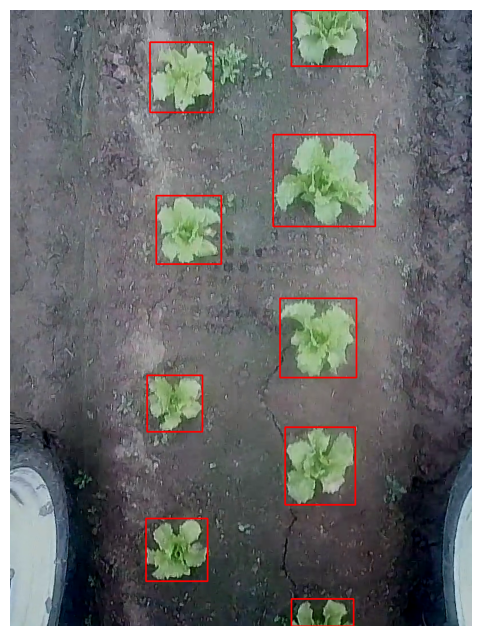

In [19]:
import os
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

train_dir = "data/detection/train"

# Pick a random image from the images directory
img_dir = os.path.join(train_dir, 'images')
lbl_dir = os.path.join(train_dir, 'labels')
img_filename = random.choice(os.listdir(img_dir))
img_path = os.path.join(img_dir, img_filename)
lbl_filename = os.path.splitext(img_filename)[0] + '.txt'
lbl_path = os.path.join(lbl_dir, lbl_filename)

# Read the image
img = cv2.imread(img_path)
if img is None:
    print("Couldn't read image:", img_path)
else:
    img_height, img_width = img.shape[:2]

    # Read label file if it exists
    if os.path.exists(lbl_path):
        with open(lbl_path, 'r') as f:
            lines = f.readlines()

        # Draw bounding boxes on the image
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            # YOLO format: class_id, x_center, y_center, width, height (all normalized)
            _, x_center, y_center, width, height = map(float, parts)
            x_center *= img_width
            y_center *= img_height
            bbox_width = width * img_width
            bbox_height = height * img_height

            # Calculate top-left and bottom-right corners
            x_min = int(x_center - bbox_width / 2)
            y_min = int(y_center - bbox_height / 2)
            x_max = int(x_center + bbox_width / 2)
            y_max = int(y_center + bbox_height / 2)

            # Draw rectangle (in red) with thickness 2
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
    else:
        print("Label file not found:", lbl_path)

    # Convert BGR to RGB for plotting
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

## Training

In [21]:
from ultralytics import YOLO

# Load the pretrained yolov8-m model
model = YOLO('yolov8s.pt')

# Train the model using the YOLO data config at data/detection/train for 50 epochs
results = model.train(data='config/detection/lettucemot.yaml', epochs=20)

100%|██████████| 21.5M/21.5M [00:01<00:00, 11.9MB/s]


Ultralytics 8.3.128 🚀 Python-3.9.21 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7933MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=config/detection/lettucemot.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

train: Scanning /home/shinobi-owl/ISU/sem2/ME_5920/project/data/detection/train/labels.cache... 861 images, 0 backgrounds, 1 corrupt: 100%|██████████| 861/861 [00:00<?, ?it/s]

train: /home/shinobi-owl/ISU/sem2/ME_5920/project/data/detection/train/images/000100.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0019]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4734.2±3640.8 MB/s, size: 1645.7 KB)


val: Scanning /home/shinobi-owl/ISU/sem2/ME_5920/project/data/detection/val/labels.cache... 223 images, 0 backgrounds, 0 corrupt: 100%|██████████| 223/223 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.01G     0.5074     0.6814     0.8821        174        640: 100%|██████████| 54/54 [00:10<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]

                   all        223       2008      0.994      0.996      0.995       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.64G     0.4163     0.3202      0.839        157        640: 100%|██████████| 54/54 [00:10<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]

                   all        223       2008      0.998      0.977      0.994      0.952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.61G     0.4088     0.3018     0.8344        192        640: 100%|██████████| 54/54 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]

                   all        223       2008      0.994      0.994      0.995      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.63G     0.4048     0.2886     0.8348        141        640: 100%|██████████| 54/54 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]

                   all        223       2008       0.99      0.984      0.995      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.64G     0.3898     0.2757     0.8335        157        640: 100%|██████████| 54/54 [00:10<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]

                   all        223       2008      0.994      0.993      0.995      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.64G     0.3671     0.2587     0.8295        156        640: 100%|██████████| 54/54 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]

                   all        223       2008      0.998      0.996      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.64G     0.3549     0.2474     0.8226        137        640: 100%|██████████| 54/54 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]

                   all        223       2008      0.997      0.996      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.62G     0.3571     0.2413     0.8268        157        640: 100%|██████████| 54/54 [00:10<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]

                   all        223       2008      0.994      0.991      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.63G     0.3537     0.2346     0.8264        153        640: 100%|██████████| 54/54 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]

                   all        223       2008      0.996      0.991      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.62G     0.3374     0.2263     0.8254        111        640: 100%|██████████| 54/54 [00:10<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]

                   all        223       2008      0.996      0.996      0.995      0.975


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.63G     0.2905     0.2096     0.7964         99        640: 100%|██████████| 54/54 [00:10<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]

                   all        223       2008      0.997      0.991      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.61G     0.2804     0.2003     0.7987         96        640: 100%|██████████| 54/54 [00:09<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]

                   all        223       2008      0.995      0.994      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.63G     0.2786     0.1922     0.8005         90        640: 100%|██████████| 54/54 [00:09<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]

                   all        223       2008      0.997      0.995      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.61G     0.2634     0.1834     0.7944         93        640: 100%|██████████| 54/54 [00:09<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.56it/s]

                   all        223       2008      0.996      0.996      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.62G     0.2637     0.1818     0.7952        103        640: 100%|██████████| 54/54 [00:09<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.58it/s]

                   all        223       2008      0.997      0.994      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.61G     0.2562     0.1762     0.7907         95        640: 100%|██████████| 54/54 [00:09<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.53it/s]

                   all        223       2008      0.996      0.995      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.61G     0.2532     0.1729     0.7899         99        640: 100%|██████████| 54/54 [00:09<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.57it/s]

                   all        223       2008      0.996      0.996      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.61G     0.2402     0.1621      0.788        100        640: 100%|██████████| 54/54 [00:09<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.55it/s]

                   all        223       2008      0.997      0.994      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.62G     0.2332     0.1543     0.7879         99        640: 100%|██████████| 54/54 [00:09<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]

                   all        223       2008      0.995      0.997      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.61G     0.2313     0.1516     0.7876         99        640: 100%|██████████| 54/54 [00:09<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.49it/s]

                   all        223       2008      0.998      0.996      0.995      0.986



20 epochs completed in 0.064 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 22.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.128 🚀 Python-3.9.21 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7933MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.12it/s]


                   all        223       2008      0.998      0.996      0.995      0.986
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train2


# Tracking

## Data

### LettuceMOT

#### Jitter

In [45]:
import random
import os
import shutil

root_dir = "data/lettucemot"
video_names = ["tmp"]

for video_name in video_names:
    video_root_dir = os.path.join(root_dir, video_name)
    gt_file = os.path.join(video_root_dir, 'gt', 'gt.txt')
    src_img_dir = os.path.join(video_root_dir, 'img')
    dest_video_dir = os.path.join(root_dir, f"{video_name}_jitter")
    dest_img_dir = os.path.join(dest_video_dir, 'images')
    dest_gt_dir = os.path.join(dest_video_dir, 'gt')
    dest_gt_path = os.path.join(dest_gt_dir, 'gt.txt')
    os.makedirs(dest_video_dir, exist_ok=True)
    os.makedirs(dest_img_dir, exist_ok=True)
    os.makedirs(dest_gt_dir, exist_ok=True)

    frame_sel = []
    for i in range(len(os.listdir(src_img_dir))):
        if i%20 <4:
            continue
        frame_sel.append(i)
    completed_frame_ids = set()
    with open(dest_gt_path, 'w') as f:
        with open(gt_file, 'r') as gt_f:
            # gt_lines = gt_f.readlines()
            # while line_idx < len(gt_lines):
            for line in gt_f:
                parts = line.strip().split(',')
                if len(parts) < 6:
                    continue
                frame_id = parts[0].strip()
                if not int(frame_id) in frame_sel:
                    continue
                new_frame_idx = frame_sel.index(int(frame_id))+1
                if not new_frame_idx in completed_frame_ids:
                    src_img_path = os.path.join(src_img_dir, f"{int(new_frame_idx):06d}.png")
                    shutil.copy(src_img_path, os.path.join(dest_img_dir, f"{new_frame_idx:06d}.png"))
                    completed_frame_ids.add(new_frame_idx)

                suff = parts[1:]
                suff_str = ','.join(suff)
                new_line = f"{new_frame_idx},{suff_str}\n"
                f.write(new_line)


#### Occlusion

In [49]:
import random
import os
import shutil
import cv2

root_dir = "data/lettucemot"
video_names = ["B&F1",'O&I1','straight1']

for video_name in video_names:
    video_root_dir = os.path.join(root_dir, video_name)
    gt_file = os.path.join(video_root_dir, 'gt', 'gt.txt')
    src_img_dir = os.path.join(video_root_dir, 'img')
    dest_video_dir = os.path.join(root_dir, f"{video_name}_occ")
    dest_img_dir = os.path.join(dest_video_dir, 'images')
    dest_gt_dir = os.path.join(dest_video_dir, 'gt')
    dest_gt_path = os.path.join(dest_gt_dir, 'gt.txt')
    os.makedirs(dest_video_dir, exist_ok=True)
    os.makedirs(dest_img_dir, exist_ok=True)
    os.makedirs(dest_gt_dir, exist_ok=True)

    for img_file in os.listdir(src_img_dir):
        img_path = os.path.join(src_img_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        h, w = img.shape[:2]
        y_mid = h // 2
        strip_thickness = 60  # adjust thickness as needed
        y1 = max(0, y_mid - strip_thickness // 2)
        y2 = min(h, y_mid + strip_thickness // 2)
        img[y1:y2, :] = 0  # add horizontal black strip
        dest_img_path = os.path.join(dest_img_dir, img_file)
        cv2.imwrite(dest_img_path, img)

## BBox+ID Plotting

In [29]:
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:

def plot_tracks(src_vid_dir, pred_file_path, dest_dir):
    # Create destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Read predictions and store them in a dictionary keyed by frame id
    tracks = {}
    with open(pred_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) < 6:
                continue
            frame_id = parts[0].strip()
            track_id = parts[1].strip()
            x = float(parts[2].strip())
            y = float(parts[3].strip())
            w = float(parts[4].strip())
            h = float(parts[5].strip())
            if int(frame_id) not in tracks:
                tracks[int(frame_id)] = []
            tracks[int(frame_id)].append((track_id, x, y, w, h))

    # List all frame images in the source directory and sort them
    frame_files = sorted(os.listdir(src_vid_dir))

    # Process each frame
    for frame_idx, frame_file in enumerate(frame_files):
        frame_path = os.path.join(src_vid_dir, frame_file)
        img = cv2.imread(frame_path)
        if img is None:
            continue

        # Extract frame id (without extension) to match the prediction key
        # frame_id = int(os.path.splitext(frame_file)[0])
        if frame_idx+1 in tracks:
            for track in tracks[frame_idx+1]:
                track_id, x, y, w, h = track
                # Determine top-left and bottom-right points
                pt1 = (int(x), int(y))
                pt2 = (int(x + w), int(y + h))
                # Draw rectangle and label
                cv2.rectangle(img, pt1, pt2, (0,0,255), 4)
                cv2.putText(img, f'ID: {track_id}', (int(x), int(y)-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 4)
        # Save the frame with drawn tracks to the destination directory
        dest_path = os.path.join(dest_dir, frame_file)
        cv2.imwrite(dest_path, img)

In [ ]:
import os


dest_root_dir = 'data/results'
src_root_dir = 'data/lettucemot'

# for model_name in os.listdir(dest_root_dir):
for model_name in ['deepocsort']:
    for video_file in os.listdir(os.path.join(dest_root_dir, model_name)):
        video_name = video_file[:-4]
        if os.path.isdir(os.path.join(dest_root_dir, model_name, video_name)):
            continue
        os.mkdir(os.path.join(dest_root_dir, model_name, video_name))
        
        ori_video_path = os.path.join(src_root_dir, video_name, 'img')
        pred_file_path = os.path.join(dest_root_dir, model_name, video_file)
        plot_tracks(ori_video_path, pred_file_path, os.path.join(dest_root_dir, model_name, video_name))

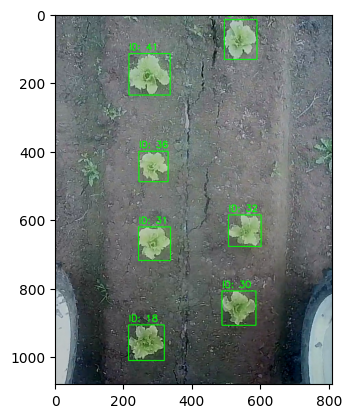

In [22]:
pred_file_path = '/home/shinobi-owl/ISU/sem2/ME_5920/project/data/results/deepocsort/B&F1.txt'
src_vid_dir = '/home/shinobi-owl/ISU/sem2/ME_5920/project/data/lettucemot/B&F1/img'
tracks = {}
with open(pred_file_path, 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) < 6:
            continue
        frame_id = parts[0].strip()
        track_id = parts[1].strip()
        x = float(parts[2].strip())
        y = float(parts[3].strip())
        w = float(parts[4].strip())
        h = float(parts[5].strip())
        if int(frame_id) not in tracks:
            tracks[int(frame_id)] = []
        tracks[int(frame_id)].append((track_id, x, y, w, h))

# List all frame images in the source directory and sort them
frame_files = sorted(os.listdir(src_vid_dir))
frame_file = frame_files[50]  # Pick the first frame for demonstration
frame_path = os.path.join(src_vid_dir, frame_file)
img = cv2.imread(frame_path)

# Extract frame id (without extension) to match the prediction key
frame_id = int(os.path.splitext(frame_file)[0])
if frame_id in tracks:
    for track in tracks[frame_id]:
        track_id, x, y, w, h = track
        # Determine top-left and bottom-right points
        pt1 = (int(x), int(y))
        pt2 = (int(x + w), int(y + h))
        # Draw rectangle and label
        cv2.rectangle(img, pt1, pt2, (0, 255, 0), 2)
        cv2.putText(img, f'ID: {track_id}', (int(x), int(y)-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [18]:
tracks

{1: [('1', 471.0, 21.0, 106.0, 113.0)],
 2: [('1', 468.0, 43.0, 106.0, 112.0)],
 3: [('1', 466.0, 66.0, 107.0, 111.0)],
 4: [('1', 465.0, 88.0, 106.0, 111.0)],
 5: [('1', 462.0, 109.0, 107.0, 111.0)],
 6: [('1', 460.0, 131.0, 106.0, 110.0)],
 7: [('1', 458.0, 154.0, 106.0, 109.0)],
 8: [('1', 459.0, 175.0, 106.0, 110.0)],
 9: [('1', 458.0, 197.0, 106.0, 110.0)],
 10: [('1', 458.0, 219.0, 106.0, 109.0)],
 11: [('1', 459.0, 242.0, 105.0, 109.0)],
 12: [('1', 459.0, 263.0, 105.0, 108.0)],
 13: [('1', 460.0, 284.0, 105.0, 108.0)],
 14: [('1', 463.0, 305.0, 105.0, 108.0)],
 15: [('1', 468.0, 327.0, 104.0, 107.0)],
 16: [('1', 468.0, 351.0, 105.0, 107.0)],
 17: [('1', 472.0, 372.0, 104.0, 108.0)],
 18: [('1', 476.0, 392.0, 104.0, 108.0)],
 19: [('1', 479.0, 415.0, 104.0, 108.0)],
 20: [('1', 483.0, 438.0, 104.0, 108.0)],
 21: [('1', 485.0, 457.0, 105.0, 109.0)],
 22: [('1', 489.0, 480.0, 104.0, 106.0)],
 23: [('1', 492.0, 500.0, 103.0, 107.0)],
 24: [('1', 494.0, 521.0, 104.0, 107.0)],
 25: 

In [5]:
import os
import shutil

# Define source and destination directories
src_dir = "data/results/strongsort/B&F1_jitter"
dst_dir = "data/results/strongsort/tmp"

vid_frames = os.listdir(src_dir)
vid_frames.sort()

for i, frame in enumerate(vid_frames):
    src_frame_path = os.path.join(src_dir, frame)
    dst_frame_path = os.path.join(dst_dir, f"{i+1:06d}.png")
    shutil.copy(src_frame_path, dst_frame_path)

In [4]:
vid_frames

['000001.png',
 '000002.png',
 '000003.png',
 '000004.png',
 '000005.png',
 '000006.png',
 '000007.png',
 '000008.png',
 '000009.png',
 '000010.png',
 '000011.png',
 '000012.png',
 '000013.png',
 '000014.png',
 '000015.png',
 '000016.png',
 '000017.png',
 '000018.png',
 '000019.png',
 '000020.png',
 '000024.png',
 '000025.png',
 '000026.png',
 '000027.png',
 '000028.png',
 '000029.png',
 '000030.png',
 '000031.png',
 '000032.png',
 '000033.png',
 '000034.png',
 '000035.png',
 '000036.png',
 '000037.png',
 '000038.png',
 '000039.png',
 '000040.png',
 '000044.png',
 '000045.png',
 '000046.png',
 '000047.png',
 '000048.png',
 '000049.png',
 '000050.png',
 '000051.png',
 '000052.png',
 '000053.png',
 '000054.png',
 '000055.png',
 '000056.png',
 '000057.png',
 '000058.png',
 '000059.png',
 '000060.png',
 '000064.png',
 '000065.png',
 '000066.png',
 '000067.png',
 '000068.png',
 '000069.png',
 '000070.png',
 '000071.png',
 '000072.png',
 '000073.png',
 '000074.png',
 '000075.png',
 '000076.p